In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
# customized module

import reconstruction  # g-force caller
import MicFileTool     # io for reconstruction rst
import IntBin          # io for binary image (reduced data)

In [1]:
# step 2: start reconstruction with calibrated configuration (parameters)
import reconstruction
import MicFileTool
import numpy as np
import matplotlib.pyplot as plt
import IntBin
import pickle
# check result of parameter get from blind search:
# NOET: in practice, might need more iterations for better configuration params
with open('data/johnson_aug18_demo/geometry_au_johnson_aug18_twiddle_1.p', 'rb') as input:
    centerL, centerJ, centerK, centerRot  = pickle.load(input)

# 
S = reconstruction.Reconstructor_GPU()
S.set_det_param(centerL, centerJ, centerK, centerRot) # set parameter
S.set_Q(7)
print(S.maxQ)

S.FZFile = '/home/hedm/work/I9_test_data/Au_Mar17/DataFiles/MyFZ.dat'         # fundamental zone file
S.set_sample('iron_bcc')
S.energy = 65.351
S.expDataInitial = '/home/hedm/work/suter_aug18/SB1_v1_v2_boxbeam/SB1_postheat_restart_V1_1degree/SB1_V1_1degree_z0_' # reduced binary data
S.expdataNDigit = 6                                                       # number of digit in the binary file name
imgsize = [50, 50]
voxelSize = 0.01
shift = [0.0, 0.0, 0.0]
S.create_square_mic(imgsize,
                    voxelsize=voxelSize,
                    shift=shift,
                   )# resolution of reconstruction and voxel size
S.squareMicOutFile = 'demoSB1_V1_Z0_johnson_aug17_' \
                    + f'{"x".join(map(str,imgsize))}_{voxelSize}' \
                    + f'_shift_{"_".join(map(str, shift))}.npy' # output file name
S.searchBatchSize = 6000   # number of orientations search at each iteration, larger number will take longer time.
S.intensity_threshold = 2 # throw away peaks with intensity below this value
S.recon_prepare(reverseRot=True)  # at 1ID, left hand rotation needs reverseRot=True
S.serial_recon_multi_stage()

#388seconds with verbose
plt.rcParams["figure.figsize"] = (10,10)
MicFileTool.plot_square_mic(S.squareMicData,0.6)
MicFileTool.plot_conf_square_mic(S.squareMicData)

(256, 3)
7
 exp data loaded, shape is: (40248317, 4).
=============start of copy exp data to gpu ===========
start of create data on cpu ram
=============start of copy exp data to CPU ===========
assuming same type of detector in different distances
=============end of copy exp data to CPU ===========
start of creating texture memory
end of creating texture memory
=============end of copy exp data to gpu ===========
==========start of reconstruction======== 

 voxelIdx: 1101, voxelLeft: 1/2500.  max hitratio: 0.699999988079071, peakcnt: 30,reconstructed euler angle [245.39312235  40.26274909  97.46080941]]]]]]number of flood fills: 252
start of post processing, moving grain boundaries untile stable
 Iteration: 4, max misorien: 0.0009765625215828number of post process iteration: 4, number of voxel revisited: 1616
 post process takes is 7.772178411483765 seconds
===========end of reconstruction========== 

SourceModule time 65.7242578125 seconds.
saved as npy format


<Figure size 1000x1000 with 1 Axes>

<Figure size 1000x1000 with 2 Axes>

# test for multiple detectors with different size and resolution:

In [3]:
# simulate binary:
# check result of parameter get from blind search:
############################# load parameters #####################3
# with open('geometry_blindsearch_0.p', 'rb') as input:
#     centerL, centerJ, centerK, centerRot  = pickle.load(input)
centerL = np.array([[4.51771003]])
centerJ = np.array([[1017.47615371]])
centerK = np.array([[2015.9392908]])
centerRot = np.array([[[ 9.00008974e+01,  8.99991399e+01, -6.16813375e-04]]])

S = reconstruction.Reconstructor_GPU()
S.NDet = 1
S.set_det_param(centerL, centerJ, centerK, centerRot) # set parameter
S.set_Q(7)

print(S.maxQ)
S.FZFile = '/home/hedm/work/I9_test_data/Au_Mar17/DataFiles/MyFZ.dat'         # fundamental zone file
S.set_sample('gold')
S.energy = 65.351
S.expdataNDigit = 6                                                       # number of digit in the binary file name
S.create_square_mic([10,10],voxelsize=0.01,shift=[0.0,0.0,0])             # resolution of reconstruction and voxel size
S.searchBatchSize = 6000                                                 # number of orientations search at each iteration, larger number will take longer time.


S.sim_mic()

# show results:
# here are the outputs:
# lenght of output is iNVoxel*iNOrientation*iNG*2*iNDet
print(len(S.aJH))
print(S.NG,S.NVoxel,2, S.NDet)
print(S.NG*S.NVoxel*2*S.NDet)
print(S.aJH) # detector location in horizental direction,pixel
print(S.aKH) # detector location in vertical direction,pixel
print(S.aOmegaH) # rotation omega, radian
print(S.bHitH) # if the peak hit the detector or not

# extract only peaks that hit the detector:
lJ = []
lK = []
lOmega = []
lRot = []
for i,hit in enumerate(S.bHitH):
    if hit:
        #print(S.aJH[i],S.aKH[i],S.aOmegaH[i],S.aiRotNH[i])
        lJ.append(S.aJH[i])
        lK.append(S.aKH[i])
        lOmega.append(S.aOmegaH[i])

(256, 3)
7
(100, 3)
(100, 3, 3)
============start of simulation ============= 

nvoxel: 100, norientation:1.0

============end of simulation================ 

SourceModule time 0.00022649599611759187 seconds.
22400
112 100 2 1
22400
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[-1.9302782  1.0029833 -1.4542826 ... -1.6873102  1.2113144 -2.1386094]
[False False False ... False False False]


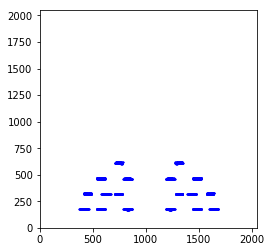

In [4]:
#visualize result
plt.scatter(2047-np.array(lJ),2047-np.array(lK),c='b',s=1)  
# sparse matrix, directly plot sigal on canvas
plt.axis('scaled')
plt.xlim((0,2048))
plt.ylim((0,2048))
plt.show()

(256, 3)
7
(100, 3)
(100, 3, 3)
============start of simulation ============= 

nvoxel: 100, norientation:1.0

============end of simulation================ 

SourceModule time 0.0002889919877052307 seconds.
[36, 32, 1966, 1964, 121, 1648, 386, 1633, 383, 1829, 31, 31, 529, 532, 1421, 1407, 1889, 1886, 386, 401, 1526, 1512, 67, 70, 613, 627, 1333, 1331, 1848, 1847, 205, 1740, 145, 148, 1842, 1846, 40, 36, 1970, 1968, 130, 1648, 386, 1635, 385, 1839, 44, 44, 538, 542, 1430, 1417, 1902, 1899, 399, 414, 1540, 1526, 81, 83, 623, 636, 1343, 1339, 1861, 1860, 215, 1750, 150, 152, 1848, 1851, 43, 40, 1973, 1972, 139, 1648, 386, 1637, 387, 1848, 57, 57, 547, 553, 1440, 1428, 1914, 1912, 413, 428, 1553, 1539, 94, 96, 633, 644, 1353, 1348, 1874, 1873, 224, 1760, 155, 157, 1853, 1855, 47, 45, 1977, 1977, 149, 1648, 386, 1639, 389, 1857, 69, 70, 557, 564, 1449, 1438, 1927, 1925, 426, 441, 1567, 1553, 107, 109, 642, 653, 1362, 1356, 1887, 1886, 234, 1770, 161, 161, 1858, 1860, 50, 49, 1980, 1981, 1

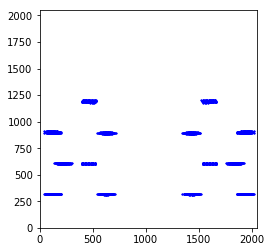

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
# customized module

import reconstruction  # g-force caller
import MicFileTool     # io for reconstruction rst
import IntBin          # io for binary image (reduced data)
# simulate binary:
# check result of parameter get from blind search:
############################# load parameters #####################3
# with open('geometry_blindsearch_0.p', 'rb') as input:
#     centerL, centerJ, centerK, centerRot  = pickle.load(input)
centerL = np.array([[4.51771003]])
centerJ = np.array([[1017.47615371]])
centerK = np.array([[2015.9392908]])
centerRot = np.array([[[ 9.00008974e+01,  8.99991399e+01, -6.16813375e-04]]])

S = reconstruction.Reconstructor_GPU()
S.NDet = 1
S.set_det_param(centerL, centerJ, centerK, centerRot,pixelJ=[0.00148/2],pixelK=[0.00148/2]) # set parameter
S.set_Q(7)

print(S.maxQ)
S.FZFile = '/home/hedm/work/I9_test_data/Au_Mar17/DataFiles/MyFZ.dat'         # fundamental zone file
S.set_sample('gold')
S.energy = 65.351
S.expdataNDigit = 6                                                       # number of digit in the binary file name
S.create_square_mic([10,10],voxelsize=0.01,shift=[0.0,0.0,0])             # resolution of reconstruction and voxel size
S.searchBatchSize = 6000                                                 # number of orientations search at each iteration, larger number will take longer time.


S.sim_mic()

# show results:
# here are the outputs:
# lenght of output is iNVoxel*iNOrientation*iNG*2*iNDet
# print(len(S.aJH))
# print(S.NG,S.NVoxel,2, S.NDet)
# print(S.NG*S.NVoxel*2*S.NDet)
# print(S.aJH) # detector location in horizental direction,pixel
# print(S.aKH) # detector location in vertical direction,pixel
# print(S.aOmegaH) # rotation omega, radian
# print(S.bHitH) # if the peak hit the detector or not

# extract only peaks that hit the detector:
lJ = []
lK = []
lOmega = []
lRot = []
for i,hit in enumerate(S.bHitH):
    if hit:
        #print(S.aJH[i],S.aKH[i],S.aOmegaH[i],S.aiRotNH[i])
        lJ.append(S.aJH[i])
        lK.append(S.aKH[i])
        lOmega.append(S.aOmegaH[i])
print(lJ)
#visualize result
plt.scatter(2047-np.array(lJ),2047-np.array(lK),c='b',s=1)  
# sparse matrix, directly plot sigal on canvas
plt.axis('scaled')
plt.xlim((0,2048))
plt.ylim((0,2048))
plt.show()

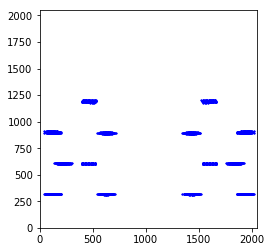

In [2]:
#visualize result
plt.scatter(2047-np.array(lJ),2047-np.array(lK),c='b',s=1)  
# sparse matrix, directly plot sigal on canvas
plt.axis('scaled')
plt.xlim((0,2048))
plt.ylim((0,2048))
plt.show()

In [10]:
idx = np.where(S.bHitH)
S.aJH[idx]
S.aKH[idx]
S.aiRotNH[idx]

array([156, 152,  22, ...,  10, 165, 168], dtype=int32)

(256, 3)
7
(100, 3)
(100, 3, 3)
============start of simulation ============= 

nvoxel: 100, norientation:1.0

============end of simulation================ 

SourceModule time 0.0003623040020465851 seconds.


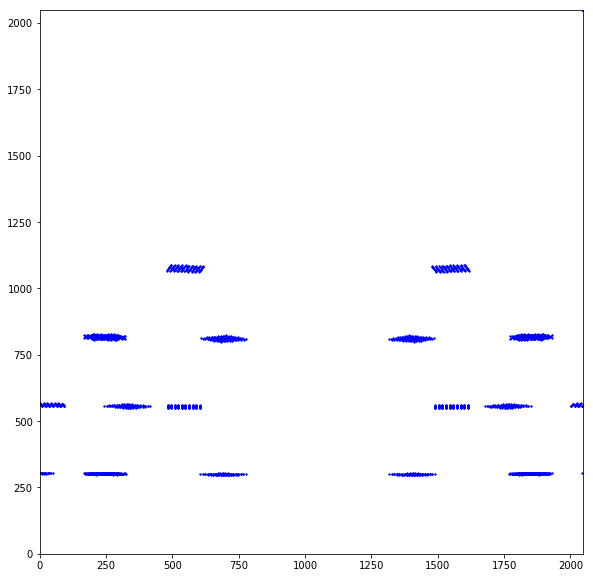

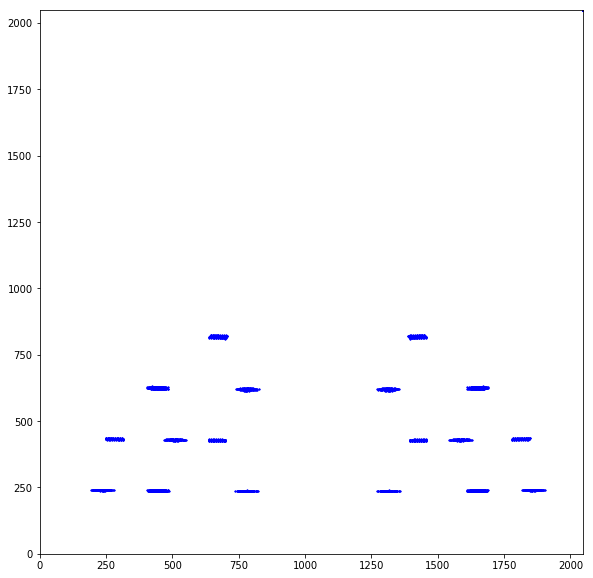

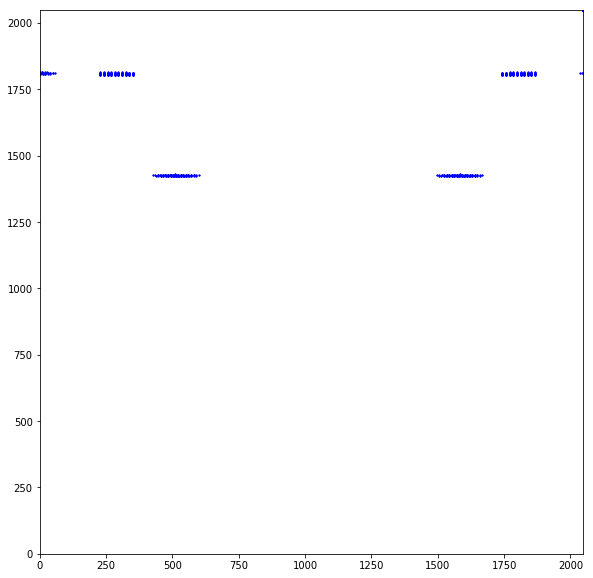

In [21]:
# test for S.aDetIdx
import numpy as np
import matplotlib.pyplot as plt
import pickle
# customized module

import reconstruction  # g-force caller
import MicFileTool     # io for reconstruction rst
import IntBin          # io for binary image (reduced data)
# simulate binary:
# check result of parameter get from blind search:
############################# load parameters #####################3
# with open('geometry_blindsearch_0.p', 'rb') as input:
#     centerL, centerJ, centerK, centerRot  = pickle.load(input)
centerL = np.array([[4,6,6]])
centerJ = np.array([[1000,1000,1000]])
centerK = np.array([[2000,2000,1000]])
centerRot = np.array([[[ 9.00008974e+01,  8.99991399e+01, -6.16813375e-04],
                      [ 9.00008974e+01,  8.99991399e+01, -6.16813375e-04],
                      [ 9.00008974e+01,  8.99991399e+01, -6.16813375e-04]]])

S = reconstruction.Reconstructor_GPU()
S.NDet = 3
S.set_det_param(centerL, centerJ, centerK, centerRot,pixelJ=[0.00148/2,0.00148,0.00148/2],pixelK=[0.00148/2,0.00148,0.00148/2]) # set parameter
S.set_Q(7)

print(S.maxQ)
S.FZFile = '/home/hedm/work/I9_test_data/Au_Mar17/DataFiles/MyFZ.dat'         # fundamental zone file
S.set_sample('gold')
S.energy = 65.351
S.expdataNDigit = 6                                                       # number of digit in the binary file name
S.create_square_mic([10,10],voxelsize=0.01,shift=[0.0,0.0,0])             # resolution of reconstruction and voxel size
S.searchBatchSize = 6000                                                 # number of orientations search at each iteration, larger number will take longer time.


S.sim_mic()

# show results:
# here are the outputs:
# lenght of output is iNVoxel*iNOrientation*iNG*2*iNDet
# print(len(S.aJH))
# print(S.NG,S.NVoxel,2, S.NDet)
# print(S.NG*S.NVoxel*2*S.NDet)
# print(S.aJH) # detector location in horizental direction,pixel
# print(S.aKH) # detector location in vertical direction,pixel
# print(S.aOmegaH) # rotation omega, radian
# print(S.bHitH) # if the peak hit the detector or not

# extract only peaks that hit the detector:
lJ = []
lK = []
lOmega = []
lRot = []
for i,hit in enumerate(S.bHitH):
    if hit and S.aDetIdx[i]==0:
        #print(S.aJH[i],S.aKH[i],S.aOmegaH[i],S.aiRotNH[i])
        lJ.append(S.aJH[i])
        lK.append(S.aKH[i])
        lOmega.append(S.aOmegaH[i])
#print(lJ)
#visualize result
plt.scatter(2047-np.array(lJ),2047-np.array(lK),c='b',s=1)  
# sparse matrix, directly plot sigal on canvas
plt.axis('scaled')
plt.xlim((0,2048))
plt.ylim((0,2048))
plt.show()

# extract only peaks that hit the detector:
lJ = []
lK = []
lOmega = []
lRot = []
for i,hit in enumerate(S.bHitH):
    if hit and S.aDetIdx[i]==1:
        #print(S.aJH[i],S.aKH[i],S.aOmegaH[i],S.aiRotNH[i])
        lJ.append(S.aJH[i])
        lK.append(S.aKH[i])
        lOmega.append(S.aOmegaH[i])
#print(lJ)
#visualize result
plt.scatter(2047-np.array(lJ),2047-np.array(lK),c='b',s=1)  
# sparse matrix, directly plot sigal on canvas
plt.axis('scaled')
plt.xlim((0,2048))
plt.ylim((0,2048))
plt.show()

# extract only peaks that hit the detector:
lJ = []
lK = []
lOmega = []
lRot = []
for i,hit in enumerate(S.bHitH):
    if hit and S.aDetIdx[i]==2:
        #print(S.aJH[i],S.aKH[i],S.aOmegaH[i],S.aiRotNH[i])
        lJ.append(S.aJH[i])
        lK.append(S.aKH[i])
        lOmega.append(S.aOmegaH[i])
#print(lJ)
#visualize result
plt.scatter(2047-np.array(lJ),2047-np.array(lK),c='b',s=1)  
# sparse matrix, directly plot sigal on canvas
plt.axis('scaled')
plt.xlim((0,2048))
plt.ylim((0,2048))
plt.show()

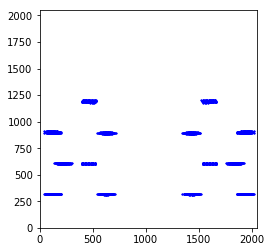

In [2]:
plt.scatter(2047-np.array(lJ),2047-np.array(lK),c='b',s=1)  
# sparse matrix, directly plot sigal on canvas
plt.axis('scaled')
plt.xlim((0,2048))
plt.ylim((0,2048))
plt.show()

In [8]:
!mkdir sim_results

(256, 3)
7


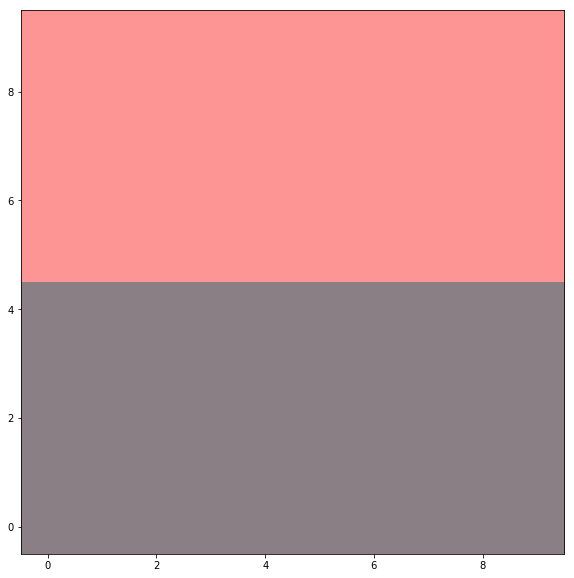

(100, 3)
(100, 3, 3)
============start of simulation ============= 

nvoxel: 100, norientation:1.0

============end of simulation================ 

SourceModule time 0.00033529600501060484 seconds.


1

In [22]:
# test for S.aDetIdx
import numpy as np
import matplotlib.pyplot as plt
import pickle
# customized module

import reconstruction  # g-force caller
import MicFileTool     # io for reconstruction rst
import IntBin          # io for binary image (reduced data)
# simulate binary:
# check result of parameter get from blind search:
############################# load parameters #####################3
# with open('geometry_blindsearch_0.p', 'rb') as input:
#     centerL, centerJ, centerK, centerRot  = pickle.load(input)
centerL = np.array([[4,6]])
centerJ = np.array([[1000,1000]])
centerK = np.array([[2000,2000]])
centerRot = np.array([[[ 9.00008974e+01,  8.99991399e+01, -6.16813375e-04],
                      [ 9.00008974e+01,  8.99991399e+01, -6.16813375e-04]]])

S = reconstruction.Reconstructor_GPU()
S.NDet = 2
S.set_det_param(centerL, centerJ, centerK, centerRot,pixelJ=[0.00148/2,0.00148],pixelK=[0.00148/2,0.00148]) # set parameter
S.set_Q(7)

print(S.maxQ)
S.FZFile = '/home/hedm/work/I9_test_data/Au_Mar17/DataFiles/MyFZ.dat'         # fundamental zone file
S.set_sample('gold')
S.energy = 65.351
S.expdataNDigit = 6                                                       # number of digit in the binary file name
S.create_square_mic([10,10],voxelsize=0.01,shift=[0.0,0.0,0])             # resolution of reconstruction and voxel size
S.searchBatchSize = 6000                                                 # number of orientations search at each iteration, larger number will take longer time.

#simulated structure is here
S.squareMicData[:,:5,3] = 10
S.squareMicData[:,:5,4] = 10
S.squareMicData[:,:5,3] = 5
S.squareMicData[:,5:,3] = 5
S.squareMicData[:,5:,4] = 90
S.squareMicData[:,5:,3] = 20

# show the structure
MicFileTool.plot_square_mic(S.squareMicData,-1)

S.sim_mic()

S.save_sim_mic_binary(fNameInitial='sim_results/sim_result_')

In [23]:
# try to reconstruct
# test for S.aDetIdx
import numpy as np
import matplotlib.pyplot as plt
import pickle
# customized module

import reconstruction  # g-force caller
import MicFileTool     # io for reconstruction rst
import IntBin          # io for binary image (reduced data)
# simulate binary:
# check result of parameter get from blind search:
############################# load parameters #####################3
# with open('geometry_blindsearch_0.p', 'rb') as input:
#     centerL, centerJ, centerK, centerRot  = pickle.load(input)
centerL = np.array([[4,6]])
centerJ = np.array([[1000,1000]])
centerK = np.array([[2000,2000]])
centerRot = np.array([[[ 9.00008974e+01,  8.99991399e+01, -6.16813375e-04],
                      [ 9.00008974e+01,  8.99991399e+01, -6.16813375e-04]]])

S = reconstruction.Reconstructor_GPU()
S.NDet = 2
S.set_det_param(centerL, centerJ, centerK, centerRot,pixelJ=[0.00148/2,0.00148],pixelK=[0.00148/2,0.00148]) # set parameter
S.set_Q(7)

print(S.maxQ)
S.FZFile = '/home/hedm/work/I9_test_data/Au_Mar17/DataFiles/MyFZ.dat'         # fundamental zone file
S.expDataInitial='sim_results/sim_result_'
S.set_sample('gold')
S.energy = 65.351
S.expdataNDigit = 0                                                       # number of digit in the binary file name
S.create_square_mic([10,10],voxelsize=0.01,shift=[0.0,0.0,0])             # resolution of reconstruction and voxel size
S.searchBatchSize = 6000                                                 # number of orientations search at each iteration, larger number will take longer time.
S.recon_prepare(reverseRot=False)
S.serial_recon_multi_stage()

(256, 3)
7
 loading det 2/2, rotation 180/180exp data loaded, shape is: (8069, 4).
=============start of copy exp data to gpu ===========
start of create data on cpu ram
=============start of copy exp data to CPU ===========
assuming same type of detector in different distances
=============end of copy exp data to CPU ===========
start of creating texture memory
end of creating texture memory
=============end of copy exp data to gpu ===========
==========start of reconstruction======== 

 voxelIdx: 94, voxelLeft: 1/100.  max hitratio: 0.9756097793579102, peakcnt: 41,reconstructed euler angle [  4.98838245  10.00079419 359.99763311]3e-03]number of flood fills: 2
start of post processing, moving grain boundaries untile stable
 Iteration: 1, max misorien: 0.0number of post process iteration: 1, number of voxel revisited: 30
 post process takes is 0.16755032539367676 seconds
===========end of reconstruction========== 

SourceModule time 6.51713818359375 seconds.
saved as npy format


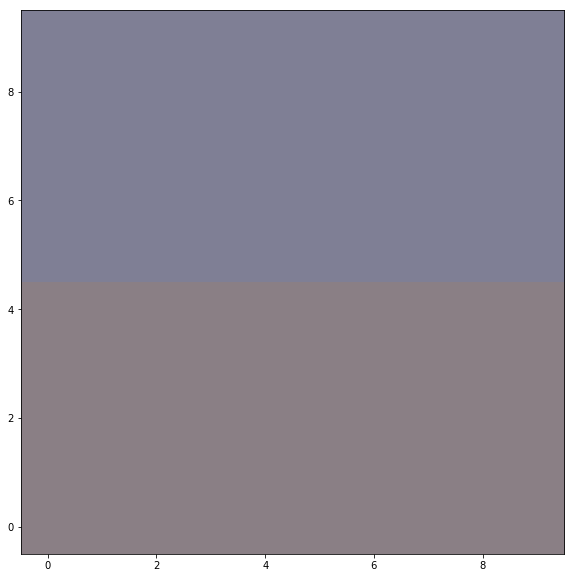

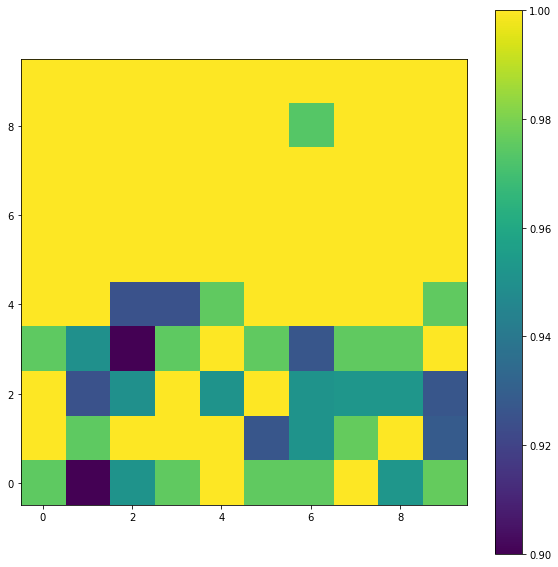

In [24]:
#388seconds with verbose
plt.rcParams["figure.figsize"] = (10,10)
MicFileTool.plot_square_mic(S.squareMicData,0.6)
MicFileTool.plot_conf_square_mic(S.squareMicData)

In [2]:
print(S.acExpDataCpuRam.shape)

(360, 2048, 0)


(256, 3)
7
(100, 3)
(100, 3, 3)
============start of simulation ============= 

nvoxel: 100, norientation:1.0

============end of simulation================ 

SourceModule time 0.00027062401175498963 seconds.


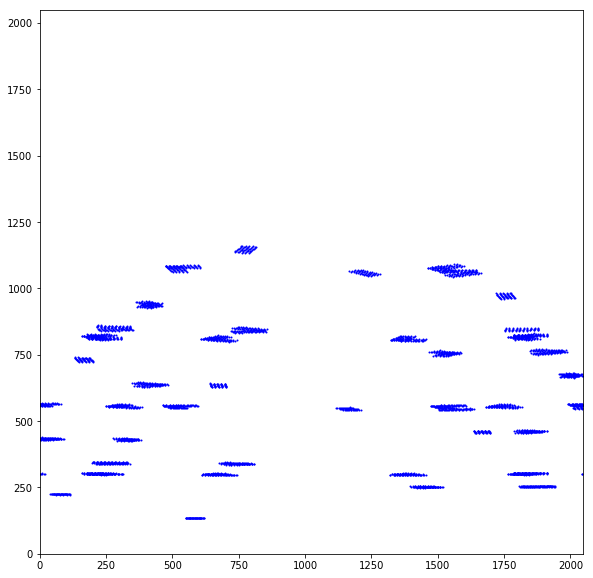

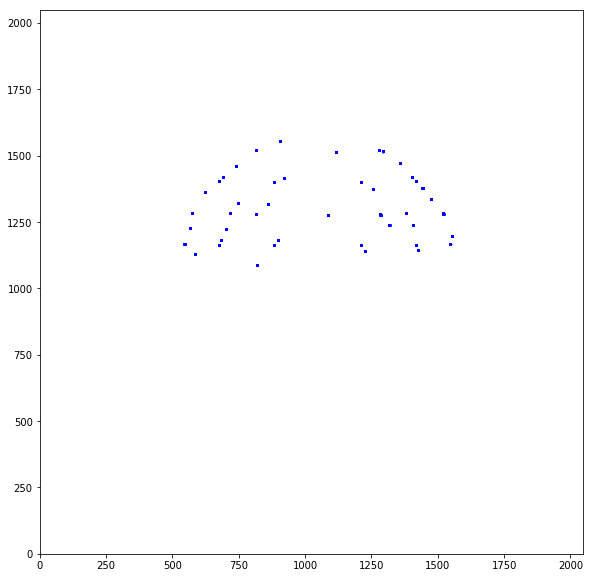

In [13]:
# test for S.aDetIdx
import numpy as np
import matplotlib.pyplot as plt
import pickle
# customized module

import reconstruction  # g-force caller
import MicFileTool     # io for reconstruction rst
import IntBin          # io for binary image (reduced data)
# simulate binary:
# check result of parameter get from blind search:
############################# load parameters #####################3
# with open('geometry_blindsearch_0.p', 'rb') as input:
#     centerL, centerJ, centerK, centerRot  = pickle.load(input)
centerL = np.array([[4,500]])
centerJ = np.array([[1000,1000]])
centerK = np.array([[2000,1000]])
centerRot = np.array([[[ 9.00008974e+01,  8.99991399e+01, -6.16813375e-04],
                      [ 9.00008974e+01,  8.99991399e+01, -6.16813375e-04]]])

S = reconstruction.Reconstructor_GPU()
S.NDet = 2
S.set_det_param(centerL, centerJ, centerK, centerRot,NJ=[2048,2000],NK=[2048,2000],pixelJ=[0.00148/2,0.2],pixelK=[0.00148/2,0.2]) # set parameter
S.set_Q(7)

print(S.maxQ)
S.FZFile = '/home/hedm/work/I9_test_data/Au_Mar17/DataFiles/MyFZ.dat'         # fundamental zone file
S.set_sample('gold')
S.energy = 65.351
S.expdataNDigit = 6                                                       # number of digit in the binary file name
S.create_square_mic([10,10],voxelsize=0.01,shift=[0.0,0.0,0])             # resolution of reconstruction and voxel size
S.searchBatchSize = 6000                                                 # number of orientations search at each iteration, larger number will take longer time.
#simulated structure is here
S.squareMicData[:,:5,3] = 10
S.squareMicData[:,:5,4] = 10
S.squareMicData[:,:5,3] = 5
S.squareMicData[:,5:,3] = 5
S.squareMicData[:,5:,4] = 90
S.squareMicData[:,5:,3] = 20

S.sim_mic()

S.save_sim_mic_binary(fNameInitial='sim_results/sim_result_')
# show results:
# here are the outputs:
# lenght of output is iNVoxel*iNOrientation*iNG*2*iNDet
# print(len(S.aJH))
# print(S.NG,S.NVoxel,2, S.NDet)
# print(S.NG*S.NVoxel*2*S.NDet)
# print(S.aJH) # detector location in horizental direction,pixel
# print(S.aKH) # detector location in vertical direction,pixel
# print(S.aOmegaH) # rotation omega, radian
# print(S.bHitH) # if the peak hit the detector or not

# extract only peaks that hit the detector:
lJ = []
lK = []
lOmega = []
lRot = []
for i,hit in enumerate(S.bHitH):
    if hit and S.aDetIdx[i]==0:
        #print(S.aJH[i],S.aKH[i],S.aOmegaH[i],S.aiRotNH[i])
        lJ.append(S.aJH[i])
        lK.append(S.aKH[i])
        lOmega.append(S.aOmegaH[i])
#print(lJ)
#visualize result
plt.scatter(2047-np.array(lJ),2047-np.array(lK),c='b',s=1)  
# sparse matrix, directly plot sigal on canvas
plt.axis('scaled')
plt.xlim((0,2048))
plt.ylim((0,2048))
plt.show()

# extract only peaks that hit the detector:
lJ = []
lK = []
lOmega = []
lRot = []
for i,hit in enumerate(S.bHitH):
    if hit and S.aDetIdx[i]==1:
        #print(S.aJH[i],S.aKH[i],S.aOmegaH[i],S.aiRotNH[i])
        lJ.append(S.aJH[i])
        lK.append(S.aKH[i])
        lOmega.append(S.aOmegaH[i])
#print(lJ)
#visualize result
plt.scatter(2047-np.array(lJ),2047-np.array(lK),c='b',s=1)  
# sparse matrix, directly plot sigal on canvas
plt.axis('scaled')
plt.xlim((0,2048))
plt.ylim((0,2048))
plt.show()


In [14]:
# try to reconstruct
# test for S.aDetIdx
import numpy as np
import matplotlib.pyplot as plt
import pickle
# customized module

import reconstruction  # g-force caller
import MicFileTool     # io for reconstruction rst
import IntBin          # io for binary image (reduced data)
# simulate binary:
# check result of parameter get from blind search:
############################# load parameters #####################3
# with open('geometry_blindsearch_0.p', 'rb') as input:
#     centerL, centerJ, centerK, centerRot  = pickle.load(input)
centerL = np.array([[4,500]])
centerJ = np.array([[1000,1000]])
centerK = np.array([[2000,1000]])
centerRot = np.array([[[ 9.00008974e+01,  8.99991399e+01, -6.16813375e-04],
                      [ 9.00008974e+01,  8.99991399e+01, -6.16813375e-04]]])
NJ=[2048,2000]
NK=[2048,2000]
pixelJ=[0.00148/2,0.2]
pixelK=[0.00148/2,0.2]
S = reconstruction.Reconstructor_GPU()
S.NDet = 2
S.set_det_param(centerL, centerJ, centerK, centerRot,NJ=NJ, NK=NK, pixelJ=pixelJ, pixelK=pixelK) # set parameter
S.set_Q(7)

print(S.maxQ)
S.FZFile = '/home/hedm/work/I9_test_data/Au_Mar17/DataFiles/MyFZ.dat'         # fundamental zone file
S.expDataInitial='sim_results/sim_result_'
S.set_sample('gold')
S.energy = 65.351
S.expdataNDigit = 0                                                       # number of digit in the binary file name
S.create_square_mic([10,10],voxelsize=0.01,shift=[0.0,0.0,0])             # resolution of reconstruction and voxel size
S.searchBatchSize = 6000                                                 # number of orientations search at each iteration, larger number will take longer time.
S.recon_prepare(reverseRot=False)
S.serial_recon_multi_stage()

(256, 3)
7
 loading det 2/2, rotation 180/180exp data loaded, shape is: (4064, 4).
=============start of copy exp data to gpu ===========
start of create data on cpu ram
=============start of copy exp data to CPU ===========
assuming same type of detector in different distances
=============end of copy exp data to CPU ===========
start of creating texture memory
end of creating texture memory
=============end of copy exp data to gpu ===========
==========start of reconstruction======== 

 voxelIdx: 94, voxelLeft: 1/100.  max hitratio: 0.9756097793579102, peakcnt: 41,reconstructed euler angle [  4.96122772   9.99955617 359.99673153]2e-03]]number of flood fills: 2
start of post processing, moving grain boundaries untile stable
 Iteration: 1, max misorien: 0.0number of post process iteration: 1, number of voxel revisited: 30
 post process takes is 0.1664893627166748 seconds
===========end of reconstruction========== 

SourceModule time 5.7463793945312505 seconds.
saved as npy format


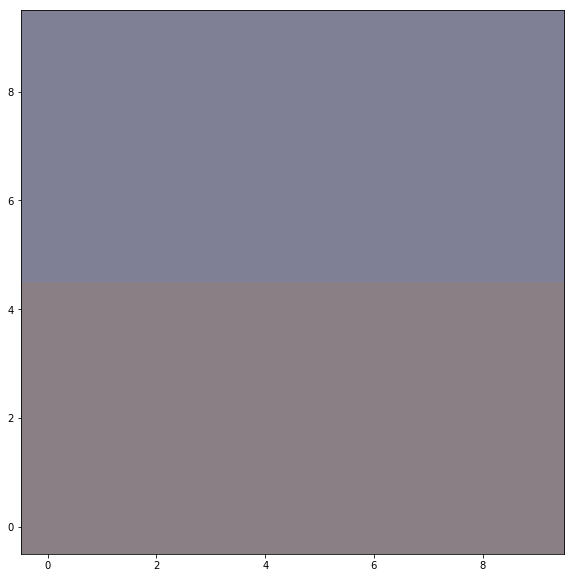

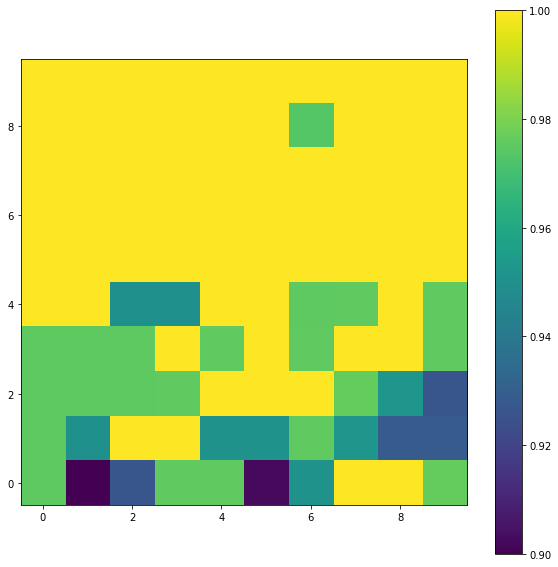

In [15]:
#388seconds with verbose
plt.rcParams["figure.figsize"] = (10,10)
MicFileTool.plot_square_mic(S.squareMicData,0.6)
MicFileTool.plot_conf_square_mic(S.squareMicData)

# input gold data and simulate:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
# customized module

import reconstruction  # g-force caller
import MicFileTool     # io for reconstruction rst
import IntBin          # io for binary image (reduced data)
# simulate binary:
# check result of parameter get from blind search:
############################# load parameters #####################3
# with open('geometry_blindsearch_0.p', 'rb') as input:
#     centerL, centerJ, centerK, centerRot  = pickle.load(input)
centerL = np.array([[4,500]])
centerJ = np.array([[1000,1000]])
centerK = np.array([[2000,1000]])
centerRot = np.array([[[ 9.00008974e+01,  8.99991399e+01, -6.16813375e-04],
                      [ 9.00008974e+01,  8.99991399e+01, -6.16813375e-04]]])

S = reconstruction.Reconstructor_GPU()
S.NDet = 2
S.set_det_param(centerL, centerJ, centerK, centerRot,NJ=[2048,2000],NK=[2048,2000],pixelJ=[0.00148/2,0.2],pixelK=[0.00148/2,0.2]) # set parameter
S.set_Q(7)

print(S.maxQ)
S.FZFile = '/home/hedm/work/I9_test_data/Au_Mar17/DataFiles/MyFZ.dat'         # fundamental zone file
S.set_sample('gold')
S.energy = 65.351
S.expdataNDigit = 6                                                       # number of digit in the binary file name
S.create_square_mic([10,10],voxelsize=0.01,shift=[0.0,0.0,0])             # resolution of reconstruction and voxel size
S.searchBatchSize = 6000                                                 # number of orientations search at each iteration, larger number will take longer time.
#simulated structure is here
S.squareMicData[:,:5,3] = 10
S.squareMicData[:,:5,4] = 10
S.squareMicData[:,:5,3] = 5
S.squareMicData[:,5:,3] = 5
S.squareMicData[:,5:,4] = 90
S.squareMicData[:,5:,3] = 20

S.sim_mic()

S.save_sim_mic_binary(fNameInitial='sim_results/sim_result_')